In [1]:
import yfinance as yf
import talib
import numpy as np
import pandas as pd
from tensorflow.keras.models import load_model
import json
from sklearn.preprocessing import MinMaxScaler

ModuleNotFoundError: No module named 'yfinance'

In [63]:
current_ticker = 'NVDA' 
stock = yf.Ticker(current_ticker)
df = stock.history(period="80d", interval="1d")
df = df.reset_index()

In [64]:
df.shape

(80, 8)

In [65]:
feature_cols = ['Open', 'Volume', 'SMA_10', 'SMA_50', 'EMA_20',
               'MACD', 'MACD_signal', 'RSI', 'BB_upper',
               'BB_lower', 'slowk', 'slowd', 'Ticker_AAPL', 'Ticker_AMZN',
               'Ticker_BRK-B', 'Ticker_GOOGL', 'Ticker_JPM', 'Ticker_META',
               'Ticker_MSFT', 'Ticker_NVDA', 'Ticker_TSLA', 'Ticker_V',
               'Month_sin', 'Month_cos', 'Day_sin', 'Day_cos']

target_cols = ['High', 'Low', 'Close']

ticker_cols = ['Ticker_AAPL', 'Ticker_AMZN', 'Ticker_BRK-B', 'Ticker_GOOGL', 
                'Ticker_JPM', 'Ticker_META', 'Ticker_MSFT', 'Ticker_NVDA', 
                'Ticker_TSLA', 'Ticker_V']

In [66]:
df['SMA_10'] = talib.SMA(df['Close'], timeperiod=10)
df['SMA_50'] = talib.SMA(df['Close'], timeperiod=50)
df['EMA_20'] = talib.EMA(df['Close'], timeperiod=20)
df['MACD'], df['MACD_signal'], df['MACD_hist'] = talib.MACD(df['Close'])
df['RSI'] = talib.RSI(df['Close'], timeperiod=14)
df['BB_upper'], df['BB_middle'], df['BB_lower'] = talib.BBANDS(df['Close'], timeperiod=20)
df['slowk'], df['slowd'] = talib.STOCH(df['High'], df['Low'], df['Close'])


In [67]:
for ticker in ticker_cols:
    df[ticker] = 1 if ticker == f'Ticker_{current_ticker}' else 0


In [68]:
df['Date'] = pd.to_datetime(df['Date'], utc=True)
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day

df['Month_sin'] = np.sin(2 * np.pi * df['Month'] / 12)
df['Month_cos'] = np.cos(2 * np.pi * df['Month'] / 12)

df['Day_sin'] = np.sin(2 * np.pi * df['Day'] / 31)
df['Day_cos'] = np.cos(2 * np.pi * df['Day'] / 31)


In [69]:
df = df.drop(columns=['Dividends','Stock Splits', 'MACD_hist', 'BB_middle', 'Day', 'Month'])


In [70]:
df = df.dropna()


In [71]:
df = df.sort_values(by='Date').reset_index(drop=True)

In [72]:
df = df.drop(['Date'], axis = 1)

In [73]:
target = df[target_cols].copy()
df.drop(columns=target_cols, inplace=True)
df = df.drop(df.index[-1])

In [83]:
last_10_timesteps = df[-10:]  # Shape will be (10, 26)

In [75]:
X_input = np.reshape(last_10_timesteps, (1, 10, 26))  # Shape: (1, 10, 26)

In [77]:
import numpy as np
import pickle

# Load scalers
with open('x_scaler_minmax.pkl', 'rb') as f:
    x_scaler = pickle.load(f)

with open('y_scaler_minmax.pkl', 'rb') as f:
    y_scaler = pickle.load(f)

# Save the shape
original_shape = X_input.shape

# Step 1: Reshape to 2D (samples * timesteps, features)
inputX_2d = X_input.reshape(-1, original_shape[2])  # shape: (1000, 5)

# Step 2: Apply scaling
inputX_scaled_2d = x_scaler.transform(inputX_2d)

# Step 3: Reshape back to 3D
inputX_scaled = inputX_scaled_2d.reshape(original_shape)


In [78]:
model = load_model('model.keras')
predictions = model.predict(inputX_scaled)
predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


array([[0.24694511, 0.24579895, 0.24649513]], dtype=float32)

In [79]:
predictions = y_scaler.inverse_transform(predictions)

In [80]:
predictions

array([[102.71388 , 100.060905, 101.40776 ]], dtype=float32)

In [81]:
actual = target[-1:]
actual = np.array(actual)
actual

array([[104.47000122, 100.05000305, 101.48999786]])

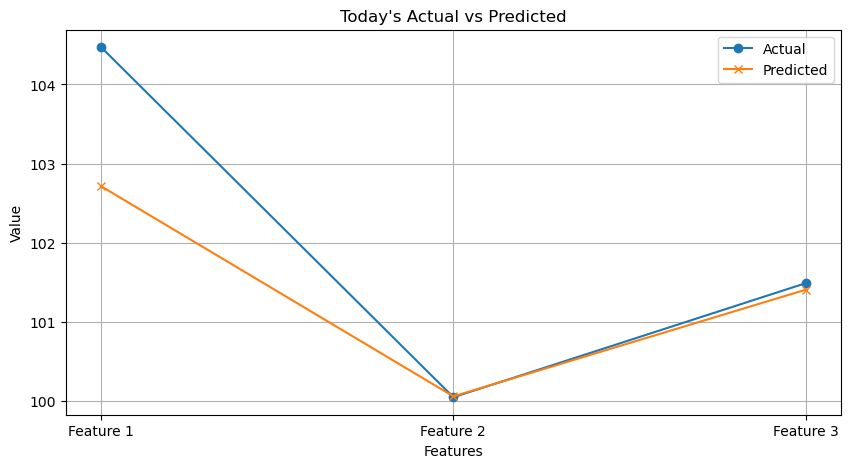

In [82]:
import matplotlib.pyplot as plt

# Flatten both to 1D arrays
actual_flat = actual.flatten()
pred_flat = predictions.flatten()

plt.figure(figsize=(10, 5))  # fixed size argument
plt.plot(actual_flat, label='Actual', marker='o')
plt.plot(pred_flat, label='Predicted', marker='x')
plt.title("Today's Actual vs Predicted")
plt.xlabel("Features")
plt.ylabel("Value")
plt.xticks(range(len(actual_flat)), ['Feature 1', 'Feature 2', 'Feature 3'])  # Optional labels
plt.legend()
plt.grid(True)
plt.show()
